# Import

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-03-04 14:54:52.135618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 14:54:52.135899: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# VAE Model

## Class Sampling

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Encoder

In [32]:
latent_dim = 32

encoder_inputs = keras.Input(shape=(64, 64, 3))

x = layers.Conv2D(8, 4, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(8, 4, activation="relu",padding="same")(x)
x = layers.Conv2D(16, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(16, 4, activation="relu", padding="same")(x)
x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 4, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 2, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 2, activation="relu", padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 32, 32, 8)    392         ['input_17[0][0]']               
                                                                                                  
 conv2d_31 (Conv2D)             (None, 32, 32, 8)    1032        ['conv2d_30[0][0]']              
                                                                                                  
 conv2d_32 (Conv2D)             (None, 16, 16, 16)   2064        ['conv2d_31[0][0]']              
                                                                                            

## Decoder

In [35]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 64))(x)


x = layers.Conv2DTranspose(64, 2, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 4, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(16, 4, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(8, 4, activation="relu", padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_19 (Dense)            (None, 1024)              33792     
                                                                 
 reshape_11 (Reshape)        (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_62 (Conv2D  (None, 8, 8, 64)         16448     
 Transpose)                                                      
                                                                 
 conv2d_39 (Conv2D)          (None, 8, 8, 64)          16448     
                                                                 
 conv2d_transpose_63 (Conv2D  (None, 16, 16, 32)       32800     
 Transpose)                                                

## VAE as a model

In [36]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Get Data

In [15]:
from icangetyoursmile.utils import get_dataset_tts

In [16]:
path = "../../raw_data"

X, y, X_test, y_test, X_visu, y_visu = get_dataset_tts(path, sample_size=1500)

Loading data from ../../raw_data/64x64/...
Done
X shape : (1275, 64, 64, 3)
y shape : (1275, 64, 64, 3)
X_test shape : (225, 64, 64, 3)
y_test shape : (225, 64, 64, 3)
X_visu shape : (5, 64, 64, 3)
y_visu shape : (5, 64, 64, 3)


In [17]:
y_st = y / 255

In [37]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [38]:
epochs = 500
batch_size = 128

In [39]:
history = vae.fit(y_st, epochs=epochs, batch_size=batch_size)

Epoch 1/500
10/10 [==============================] - 4s 301ms/step - loss: 800.3703 - reconstruction_loss: 793.5887 - kl_loss: 0.0039
Epoch 2/500
10/10 [==============================] - 3s 301ms/step - loss: 764.8605 - reconstruction_loss: 760.4448 - kl_loss: 0.0243
Epoch 3/500
10/10 [==============================] - 3s 299ms/step - loss: 748.8971 - reconstruction_loss: 739.2015 - kl_loss: 1.3798
Epoch 4/500
10/10 [==============================] - 3s 300ms/step - loss: 713.4909 - reconstruction_loss: 701.7531 - kl_loss: 6.9671
Epoch 5/500
10/10 [==============================] - 3s 294ms/step - loss: 682.2731 - reconstruction_loss: 666.0446 - kl_loss: 7.1957
Epoch 6/500
10/10 [==============================] - 3s 290ms/step - loss: 661.5253 - reconstruction_loss: 650.6185 - kl_loss: 5.4097
Epoch 7/500
10/10 [==============================] - 3s 293ms/step - loss: 644.7852 - reconstruction_loss: 633.3326 - kl_loss: 5.6688
Epoch 8/500
10/10 [==============================] - 3s 291ms/

10/10 [==============================] - 3s 307ms/step - loss: 361.5885 - reconstruction_loss: 330.0814 - kl_loss: 30.9629
Epoch 62/500
10/10 [==============================] - 3s 307ms/step - loss: 361.1061 - reconstruction_loss: 327.2654 - kl_loss: 31.6663
Epoch 63/500
10/10 [==============================] - 3s 317ms/step - loss: 359.5627 - reconstruction_loss: 331.1422 - kl_loss: 31.5182
Epoch 64/500
10/10 [==============================] - 3s 314ms/step - loss: 367.3171 - reconstruction_loss: 336.1509 - kl_loss: 30.5944
Epoch 65/500
10/10 [==============================] - 3s 308ms/step - loss: 363.1853 - reconstruction_loss: 331.5430 - kl_loss: 30.6166
Epoch 66/500
10/10 [==============================] - 3s 309ms/step - loss: 354.2938 - reconstruction_loss: 324.0891 - kl_loss: 31.5454
Epoch 67/500
10/10 [==============================] - 3s 296ms/step - loss: 355.7023 - reconstruction_loss: 326.4758 - kl_loss: 31.3504
Epoch 68/500
10/10 [==============================] - 3s 301m

10/10 [==============================] - 3s 306ms/step - loss: 331.4031 - reconstruction_loss: 299.8793 - kl_loss: 31.8785
Epoch 122/500
10/10 [==============================] - 3s 314ms/step - loss: 335.3014 - reconstruction_loss: 303.5778 - kl_loss: 31.3734
Epoch 123/500
10/10 [==============================] - 3s 311ms/step - loss: 331.4050 - reconstruction_loss: 299.1205 - kl_loss: 31.6396
Epoch 124/500
10/10 [==============================] - 3s 319ms/step - loss: 327.3904 - reconstruction_loss: 296.5547 - kl_loss: 32.0416
Epoch 125/500
10/10 [==============================] - 3s 318ms/step - loss: 328.7949 - reconstruction_loss: 295.1066 - kl_loss: 31.8331
Epoch 126/500
10/10 [==============================] - 3s 314ms/step - loss: 326.4181 - reconstruction_loss: 294.2548 - kl_loss: 32.1781
Epoch 127/500
10/10 [==============================] - 3s 315ms/step - loss: 326.0482 - reconstruction_loss: 293.4329 - kl_loss: 32.1495
Epoch 128/500
10/10 [==============================] - 

10/10 [==============================] - 3s 332ms/step - loss: 312.9054 - reconstruction_loss: 279.6920 - kl_loss: 32.0382
Epoch 181/500
10/10 [==============================] - 3s 328ms/step - loss: 310.1016 - reconstruction_loss: 276.8033 - kl_loss: 32.5353
Epoch 182/500
10/10 [==============================] - 3s 307ms/step - loss: 312.0280 - reconstruction_loss: 279.8498 - kl_loss: 32.0224
Epoch 183/500
10/10 [==============================] - 3s 304ms/step - loss: 312.2909 - reconstruction_loss: 278.3562 - kl_loss: 32.1699
Epoch 184/500
10/10 [==============================] - 3s 295ms/step - loss: 309.5757 - reconstruction_loss: 277.3701 - kl_loss: 32.4025
Epoch 185/500
10/10 [==============================] - 3s 294ms/step - loss: 310.5258 - reconstruction_loss: 279.4454 - kl_loss: 32.0722
Epoch 186/500
10/10 [==============================] - 3s 295ms/step - loss: 313.7225 - reconstruction_loss: 281.7586 - kl_loss: 31.9068
Epoch 187/500
10/10 [==============================] - 

10/10 [==============================] - 3s 291ms/step - loss: 298.9162 - reconstruction_loss: 264.4457 - kl_loss: 32.7748
Epoch 240/500
10/10 [==============================] - 3s 300ms/step - loss: 295.1439 - reconstruction_loss: 266.7375 - kl_loss: 32.4100
Epoch 241/500
10/10 [==============================] - 3s 300ms/step - loss: 301.2678 - reconstruction_loss: 269.8384 - kl_loss: 32.0942
Epoch 242/500
10/10 [==============================] - 3s 288ms/step - loss: 296.8582 - reconstruction_loss: 264.6934 - kl_loss: 32.2897
Epoch 243/500
10/10 [==============================] - 3s 292ms/step - loss: 295.6772 - reconstruction_loss: 263.3361 - kl_loss: 32.8165
Epoch 244/500
10/10 [==============================] - 3s 296ms/step - loss: 294.8341 - reconstruction_loss: 262.8741 - kl_loss: 32.7368
Epoch 245/500
10/10 [==============================] - 3s 296ms/step - loss: 297.9811 - reconstruction_loss: 267.8069 - kl_loss: 32.3817
Epoch 246/500
10/10 [==============================] - 

10/10 [==============================] - 3s 295ms/step - loss: 288.9039 - reconstruction_loss: 255.0744 - kl_loss: 32.8642
Epoch 299/500
10/10 [==============================] - 3s 294ms/step - loss: 289.1629 - reconstruction_loss: 255.2575 - kl_loss: 33.1784
Epoch 300/500
10/10 [==============================] - 3s 298ms/step - loss: 288.1542 - reconstruction_loss: 254.5699 - kl_loss: 32.8866
Epoch 301/500
10/10 [==============================] - 3s 290ms/step - loss: 286.1056 - reconstruction_loss: 254.6292 - kl_loss: 32.7341
Epoch 302/500
10/10 [==============================] - 3s 289ms/step - loss: 285.9862 - reconstruction_loss: 255.6639 - kl_loss: 32.7175
Epoch 303/500
10/10 [==============================] - 3s 295ms/step - loss: 290.9245 - reconstruction_loss: 258.4534 - kl_loss: 32.5707
Epoch 304/500
10/10 [==============================] - 3s 299ms/step - loss: 288.8634 - reconstruction_loss: 256.5093 - kl_loss: 32.8870
Epoch 305/500
10/10 [==============================] - 

10/10 [==============================] - 3s 307ms/step - loss: 287.9457 - reconstruction_loss: 255.3212 - kl_loss: 32.4883
Epoch 358/500
10/10 [==============================] - 3s 296ms/step - loss: 283.9015 - reconstruction_loss: 251.5913 - kl_loss: 32.9883
Epoch 359/500
10/10 [==============================] - 3s 307ms/step - loss: 281.9269 - reconstruction_loss: 249.0566 - kl_loss: 32.9951
Epoch 360/500
10/10 [==============================] - 3s 304ms/step - loss: 280.2110 - reconstruction_loss: 246.3298 - kl_loss: 33.2892
Epoch 361/500
10/10 [==============================] - 3s 303ms/step - loss: 281.6563 - reconstruction_loss: 248.2055 - kl_loss: 32.9264
Epoch 362/500
10/10 [==============================] - 3s 317ms/step - loss: 283.2402 - reconstruction_loss: 253.0890 - kl_loss: 32.6387
Epoch 363/500
10/10 [==============================] - 3s 310ms/step - loss: 284.3368 - reconstruction_loss: 249.7639 - kl_loss: 32.9568
Epoch 364/500
10/10 [==============================] - 

10/10 [==============================] - 3s 298ms/step - loss: 276.2850 - reconstruction_loss: 244.0300 - kl_loss: 33.5897
Epoch 417/500
10/10 [==============================] - 3s 310ms/step - loss: 276.4257 - reconstruction_loss: 242.6106 - kl_loss: 33.3129
Epoch 418/500
10/10 [==============================] - 3s 340ms/step - loss: 274.9198 - reconstruction_loss: 242.1192 - kl_loss: 33.4368
Epoch 419/500
10/10 [==============================] - 3s 321ms/step - loss: 283.6781 - reconstruction_loss: 251.3117 - kl_loss: 32.8929
Epoch 420/500
10/10 [==============================] - 3s 318ms/step - loss: 281.6299 - reconstruction_loss: 246.1351 - kl_loss: 33.2334
Epoch 421/500
10/10 [==============================] - 3s 312ms/step - loss: 275.3066 - reconstruction_loss: 242.7980 - kl_loss: 33.4003
Epoch 422/500
10/10 [==============================] - 3s 319ms/step - loss: 276.9216 - reconstruction_loss: 243.0071 - kl_loss: 33.2878
Epoch 423/500
10/10 [==============================] - 

10/10 [==============================] - 3s 298ms/step - loss: 274.5394 - reconstruction_loss: 242.1336 - kl_loss: 33.4405
Epoch 476/500
10/10 [==============================] - 3s 308ms/step - loss: 274.6819 - reconstruction_loss: 241.1618 - kl_loss: 32.8664
Epoch 477/500
10/10 [==============================] - 3s 318ms/step - loss: 273.5637 - reconstruction_loss: 238.9471 - kl_loss: 33.4510
Epoch 478/500
10/10 [==============================] - 3s 307ms/step - loss: 274.7787 - reconstruction_loss: 241.7888 - kl_loss: 33.3392
Epoch 479/500
10/10 [==============================] - 3s 313ms/step - loss: 277.0371 - reconstruction_loss: 243.8188 - kl_loss: 33.3020
Epoch 480/500
10/10 [==============================] - 3s 310ms/step - loss: 273.5195 - reconstruction_loss: 242.5325 - kl_loss: 32.6639
Epoch 481/500
10/10 [==============================] - 3s 302ms/step - loss: 270.8963 - reconstruction_loss: 237.7085 - kl_loss: 33.5494
Epoch 482/500
10/10 [==============================] - 

In [40]:
loss = history.history["loss"]
r_loss = history.history["reconstruction_loss"]
kl_loss = history.history["kl_loss"]
epoch_range = range(epochs)
epoch_range

range(0, 500)

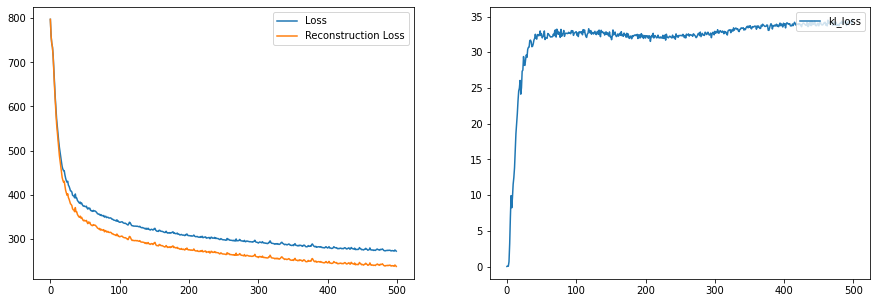

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

#Plot Loss & Reconstruction Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label="Loss")
plt.plot(epoch_range, r_loss, label="Reconstruction Loss")
plt.legend(loc="upper right")

#Plot kl_loss
plt.subplot(1,2,2)
plt.plot(epoch_range, kl_loss, label="kl_loss")
plt.legend(loc="upper right")


plt.show()

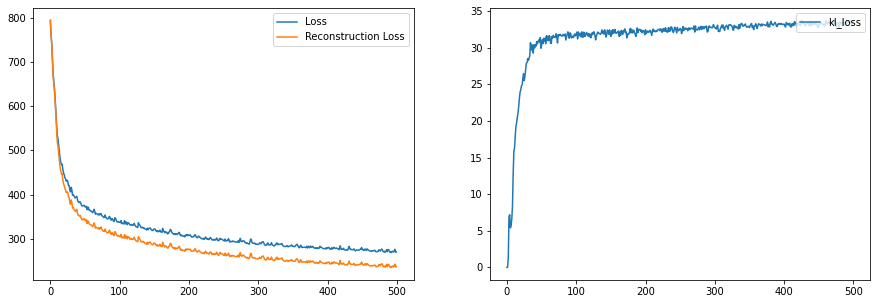

In [41]:
plt.figure(figsize=(15,5))

#Plot Loss & Reconstruction Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label="Loss")
plt.plot(epoch_range, r_loss, label="Reconstruction Loss")
plt.legend(loc="upper right")

#Plot kl_loss
plt.subplot(1,2,2)
plt.plot(epoch_range, kl_loss, label="kl_loss")
plt.legend(loc="upper right")


plt.show()

In [42]:
import matplotlib.image as mpimg

In [44]:
res = vae.encoder.predict(y_st)

In [45]:
res_f = vae.decoder.predict(res[1])

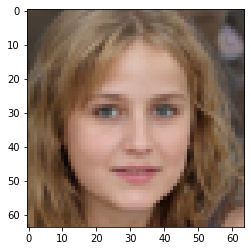

In [46]:
plt.imshow(y[1])

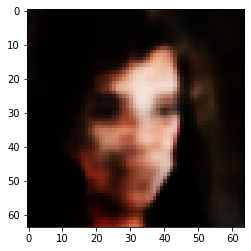

In [47]:
plt.imshow(res_f[1])